In [6]:
!pip install pandas numpy matplotlib seaborn xgboost scikit-learn --quiet

In [10]:
from google.colab import files

print("")
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('traffic.csv')

print("Data loaded!")
print(df.shape)
print(df.head())

Ab traffic.csv file upload kar (Kaggle se download kar le pehle)


Saving traffic.csv to traffic (2).csv
Data loaded!
(48120, 4)
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


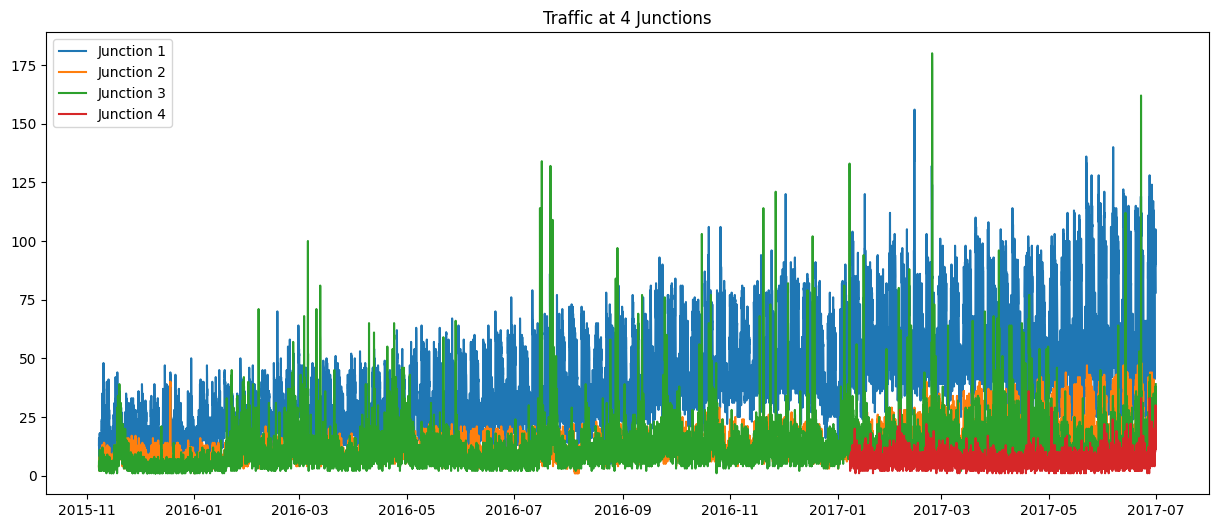

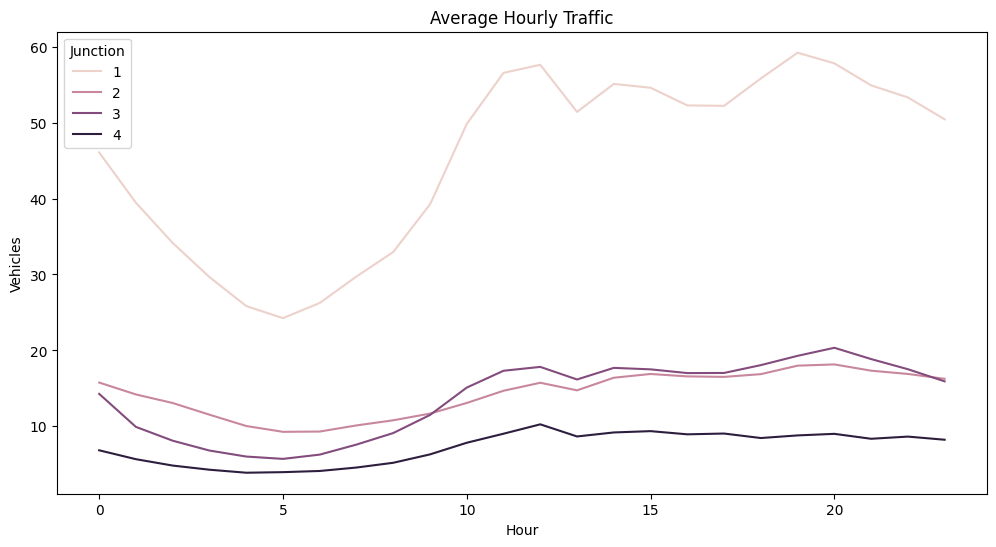

RMSE: 4.93


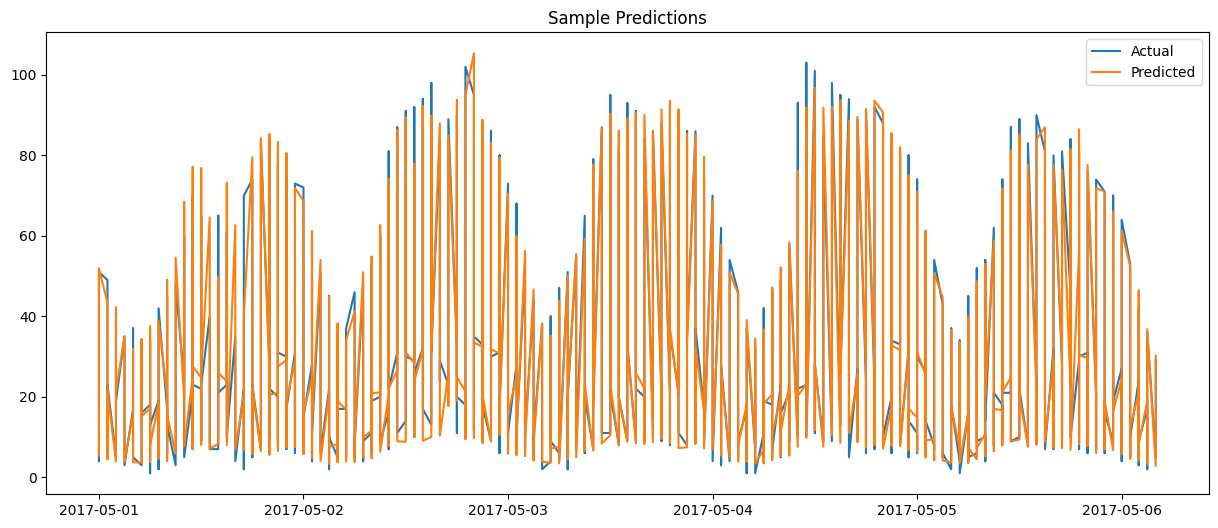

Sab done bhai!


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# EDA
plt.figure(figsize=(15,6))
for j in [1,2,3,4]:
    temp = df[df['Junction'] == j]
    plt.plot(temp['DateTime'], temp['Vehicles'], label=f'Junction {j}')
plt.legend()
plt.title('Traffic at 4 Junctions')
plt.show()

df['Hour'] = df['DateTime'].dt.hour
hourly = df.groupby(['Junction', 'Hour'])['Vehicles'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(x='Hour', y='Vehicles', hue='Junction', data=hourly)
plt.title('Average Hourly Traffic')
plt.show()

# Features
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

lags = [1,2,24,48,168]
for lag in lags:
    df[f'lag_{lag}'] = df.groupby('Junction')['Vehicles'].shift(lag)

df['roll_mean_24'] = df.groupby('Junction')['Vehicles'].shift(1).rolling(24).mean()

# Split data before dropping NaNs to preserve test set integrity
train = df[df['DateTime'] < '2017-05-01']
test = df[df['DateTime'] >= '2017-05-01']

# Drop NaNs after splitting, as lag features introduce them
train = train.dropna()
test = test.dropna()

features = ['hour', 'dayofweek', 'month', 'is_weekend'] + [f'lag_{l}' for l in lags] + ['roll_mean_24', 'Junction']
X_train = pd.get_dummies(train[features], columns=['Junction'])
X_test = pd.get_dummies(test[features], columns=['Junction'])

# Ensure X_test has the same columns as X_train, filling missing with 0
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train['Vehicles']
y_test = test['Vehicles']

# Model
model = xgb.XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse:.2f}")  # 6-9 ke around aayeg

# Plot
plt.figure(figsize=(15,6))
plt.plot(test['DateTime'][:500], y_test[:500], label='Actual')
plt.plot(test['DateTime'][:500], preds[:500], label='Predicted')
plt.legend()
plt.title('Sample Predictions')
plt.show()

print("done")

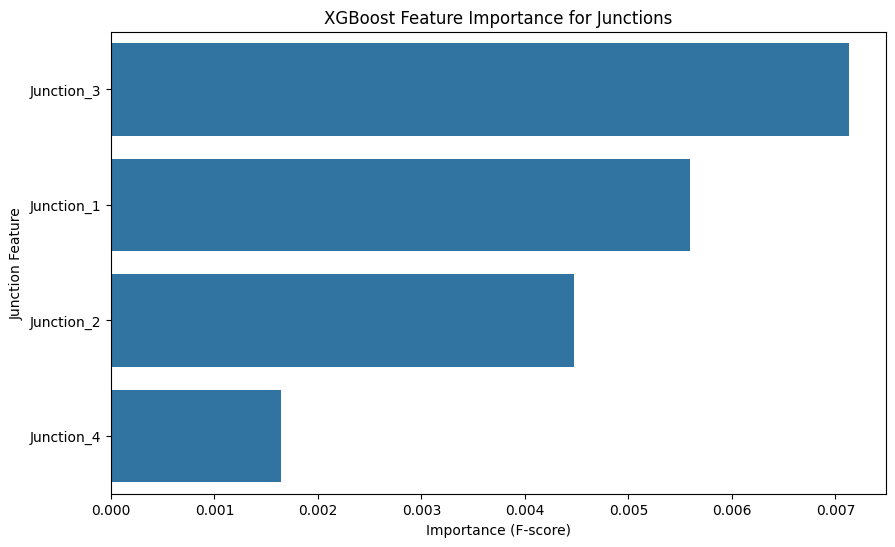

In [14]:
# Filter importance_df for junction-specific features
junction_importance_df = importance_df[importance_df['Feature'].str.startswith('Junction_')]

# Plot the feature importances for junctions
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=junction_importance_df)
plt.title('XGBoost Feature Importance for Junctions')
plt.xlabel('Importance (F-score)')
plt.ylabel('Junction Feature')
plt.show()

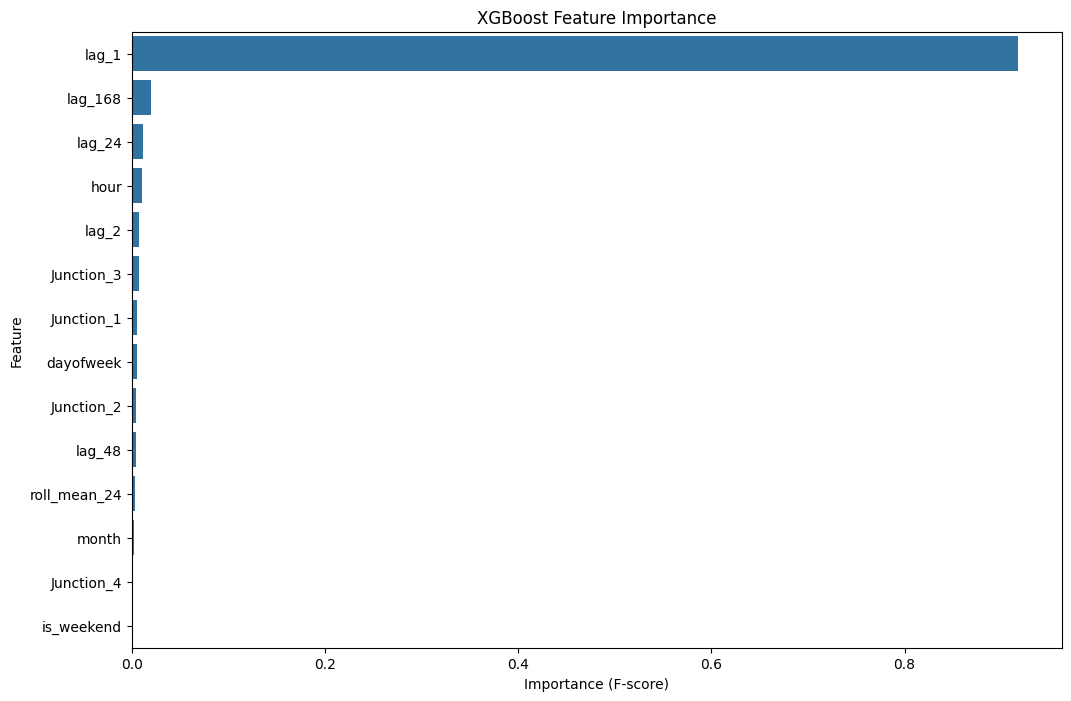

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (F-score)')
plt.ylabel('Feature')
plt.show()